In [1]:
import pandas as pd
import numpy as np

import re

from matplotlib import colors, rc, rcParams
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopandas as gpd
import folium

from shapely.geometry import polygon, multipolygon, Point

import mapclassify as mc
import libpysal as lp

from esda import moran # Morans
from splot.esda import plot_moran, moran_scatterplot

from scipy.stats import shapiro, boxcox

from statsmodels.stats.multitest import multipletests

import contextily as ctx

In [6]:
def set_style():
#     sns.set_context("paper")
#     sns.set(font='serif')
#     sns.set_style("white", {
#         "font.family": "serif",
#         "font.serif": ["Times", "Palatino", "serif"]
#     })
    
#     rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# #     rc('text', usetex=True)
    
#     rcParams['text.usetex']=True
# #     rcParams['text.latex.unicode']=True

    rcParams['mathtext.fontset'] = 'cm'
#     rcParams['font.family'] = 'cmu serif'#'STIXGeneral'
    rcParams['figure.dpi']=300
#     plt.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
    
#     plt.style.use(['seaborn-white', 'seaborn-paper'])

set_style()

In [ ]:
def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
        [0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        [0.9, 0.9, 0.9],          # light gray
        [0.984375, 0.7265625, 0], # dark yellow
        [1, 1, 0.9]               # light yellow
    ])

## Load District boundaries

In [4]:
districts_pop_gdf = gpd.read_file('data/Bangkok-saturated-districts.shp')

districts_pop_gdf = districts_pop_gdf[['district','venue_va_1','geometry']]
districts_pop_gdf.columns = ['district','venue_val_per_capita','geometry']
districts_pop_gdf

,district,venue_val_per_capita,geometry
0,Ban Na,0.001687,"POLYGON ((101.06481 14.41179, 101.06536 14.410..."
1,Ban Pho,0.002365,"POLYGON ((100.96163 13.70401, 100.96242 13.703..."
2,Bang Bo,0.001102,"POLYGON ((100.93635 13.66819, 100.93792 13.667..."
3,Bang Bon,0.000474,"POLYGON ((100.43022 13.67181, 100.42820 13.669..."
4,Bang Bua Thong,0.001762,"POLYGON ((100.38375 13.98669, 100.38609 13.986..."
...,...,...,...
78,Wang Noi,0.001517,"POLYGON ((100.82285 14.32829, 100.82439 14.326..."
79,Wang Thonglang,0.001202,"POLYGON ((100.58796 13.80530, 100.58826 13.805..."
80,Wattana,0.005168,"POLYGON ((100.55692 13.75175, 100.55806 13.751..."
81,Wihan Daeng,0.000716,"POLYGON ((100.99131 14.42083, 100.99177 14.418..."


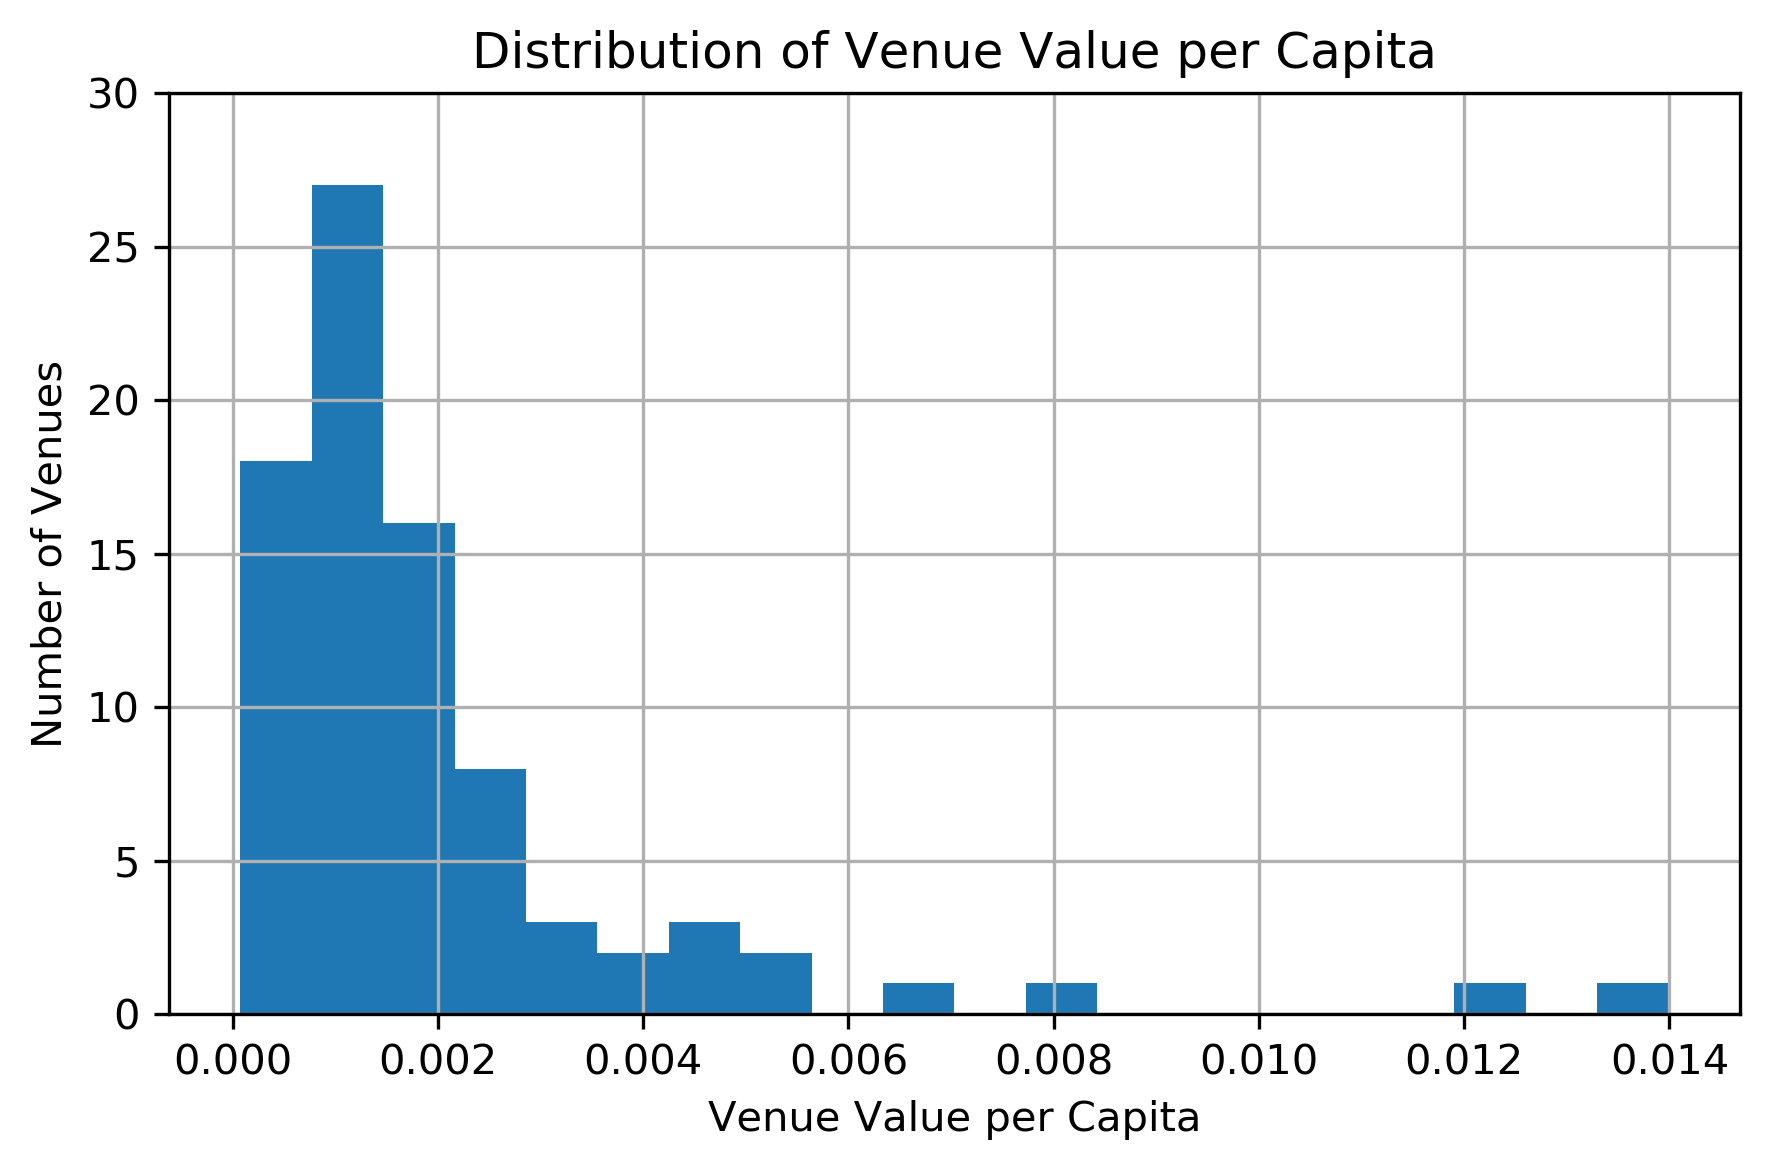

In [7]:
ax = districts_pop_gdf.venue_val_per_capita.hist(bins=20, figsize=(6,4))
plt.title('Distribution of Venue Value per Capita')
plt.ylim(0,30)
plt.xlabel('Venue Value per Capita')
plt.ylabel('Number of Venues')
# sns.despine(ax=ax, left=True)
# sns.despine(ax=axes[2], left=True)

plt.tight_layout()
# plt.savefig('data/output_venuevalue.svg')
plt.show()

In [ ]:
boxcox_venue_val_per_capita = boxcox(districts_pop_gdf.venue_val_per_capita)
districts_pop_gdf['boxcox_venue_val_per_capita'] = boxcox_venue_val_per_capita[0]

In [ ]:
districts_pop_gdf.boxcox_venue_val_per_capita.hist(bins=20, figsize=(6,4))
plt.ylim(0,30)
plt.title('Distribution of boxcox(Venue Value per Capita)')
plt.xlabel('boxcox(Venue Value per Capita)')
plt.ylabel('Number of Venues')
plt.tight_layout()
plt.savefig('data/output_boxcoxvenuevalue.svg')
plt.show()

## Venue Value per Capita per District - Global Morans

Global autocorrelation test - is the distribution of food venues random?

In [ ]:
# Generate weights matrix with Queen first-order contiguity

wq = lp.weights.Queen.from_dataframe(districts_pop_gdf, idVariable='district')
wq.transform = 'r'

In [ ]:
# Confirm no islands
wq.islands

In [ ]:
# Inspect connectivity of districts
neigh_list = [len(d) for d in wq.neighbors.values()]

print('Queens weight median neighbors: ', np.median(neigh_list))
print('Queens weight average neighbors: ', np.average(neigh_list))
print('Queens weight max neighbors: ', np.max(neigh_list))
print('Queens weight min neighbors: ', np.min(neigh_list))

In [ ]:
# Compute spatial lag - the weighted average of food venue value per capita per district
# The spatial leg standardizes the rows and takes the average value of all venues in each district.

y = districts_pop_gdf['boxcox_venue_val_per_capita']
ylag = lp.weights.lag_spatial(wq, y)
ylag[0:5]

In [ ]:
districts_pop_gdf['lag_boxcox_venue_val_per_capita'] = ylag #make this _gdf
f,ax = plt.subplots(1,2,figsize=(20,10))

districts_pop_gdf.plot(column='venue_val_per_capita', ax=ax[0], edgecolor='grey',
        scheme="quantiles",  k=10, cmap='Purples')
ax[0].axis(districts_pop_gdf.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Venue value per capita")

districts_pop_gdf.plot(column='lag_boxcox_venue_val_per_capita', ax=ax[1], edgecolor='grey',
        scheme='quantiles', cmap='Purples', k=10)
ax[1].axis(districts_pop_gdf.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag venue value per capita")
ax[0].axis('off')
ax[1].axis('off')

plt.show()

In [ ]:
np.random.seed(123)
mi = moran.Moran(y, wq, permutations=9999, two_tailed=False)

sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [ ]:
# A p-value of 0.05 and less is significant
mi.p_sim

In [ ]:
# Globally, distribution is statistically significant. 
# We reject our null hypothesis that venue distribution is random.
# Instead, we have significant clustering of 'like' values

## Local Autocorrelation

In [ ]:
# since .05/N is on the order of 1e − 4,
# we need at least 10,000 to establish whether a simulation is anomalous
li = moran.Moran_Local(y, wq, permutations=9999)

# Determine number of statistically-significant hotspots/coldspots
print('Num clusters/outliers: ', (li.p_sim < 0.05).sum())

In [ ]:
print('Num clusters/outliers: ', (li.p_sim < 0.0006).sum())

In [ ]:
moran_scatterplot(li)

In [ ]:
moran_scatterplot(li, p=0.05) # consider p=0.0006 - Bonferroni correction
plt.show()

In [ ]:
moran_scatterplot(li, p=0.0006) # Bonferroni correction
plt.show()

In [ ]:
# Apply Benjamini/Hochberg False Discovery Rate to p-values, 
# a less conservative correction than Bonferroni approach
fdr_corrected_pval = multipletests(li.p_sim, method='fdr_bh')

districts_pop_gdf.loc[:,'p_fdr'] = fdr_corrected_pval[1]
districts_pop_gdf.loc[:,'fdr_significant'] = fdr_corrected_pval[0]

districts_pop_gdf.head()

In [ ]:
districts_pop_gdf[['district','p_n','p_r','p_fdr','fdr_significant']].sort_values('p_fdr')[0:15]

In [ ]:
# Instead of 0.05 limit, use FDR-corrected upper bound
P_VAL = 0.0048

In [ ]:
moran_scatterplot(li, p=P_VAL) # FDR correction
plt.show()

In [ ]:
sig = 1 * (li.p_sim < P_VAL)

hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)

spots = hotspot + coldspot + doughnut + diamond
spots

In [ ]:
spot_labels = ['0 not significant', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

In [ ]:
# districts_pop_gdf.loc[:,'cluster_category'] = labels
# districts_pop_gdf.loc[:,'I_i'] = li.Is
# districts_pop_gdf.loc[:,'p_r'] = li.p_sim
# districts_pop_gdf.loc[:,'p_n'] = li.p_z_sim
# districts_pop_gdf.loc[:,'z_score'] = li.z_sim
districts_pop_gdf.loc[:,'morans_quadrant'] = li.q
# districts_pop_gdf.loc[:,'cluster_category'] = districts_pop_gdf['cluster_category'].astype('category')
districts_pop_gdf.head()

In [ ]:
districts_pop_gdf.loc[:,'p_r_singificance'] = districts_pop_gdf.p_r.apply(lambda p: p if p < 0.05 else None)

In [ ]:
li.q

In [ ]:
districts_pop_gdf

In [ ]:
# hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue']) # 'pink' for diamonds excluded with zero data points

ax = districts_pop_gdf.plot(color='lightgrey', linewidth=0.01, figsize=(10, 7))

def get_sig_bin(p_r):
    if (p_r > 0.01):
        return 0.05
    if (p_r > P_VAL):
        return 0.01
    if (p_r > 0.001):
        return P_VAL
    if (p_r > 0.0006): # Bonferroni
        return 0.001
    return 0.0006

sig_districts_gdf = districts_pop_gdf.dropna()
sig_districts_gdf.loc[:,'sig_bin'] = sig_districts_gdf.p_r.apply(get_sig_bin)

sig_districts_gdf.plot(column='sig_bin', ax=ax, categorical=True,\
        k=5, cmap='Greens_r', linewidth=0.1,\
        edgecolor='white', legend=True) # , missing_kwds={'color': "lightgrey"}) Not available yet
ax.set_axis_off()

plt.title('Local Moran\'s I of Food venue value per capita in Bangkok')
plt.show()

In [ ]:
districts_pop_gdf.assign?

In [ ]:
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue']) # 'pink' for diamonds excluded with zero data points
f, ax = plt.subplots(1, figsize=(20, 14))

districts_pop_gdf.plot(column='cluster_category', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

plt.title('Local Moran\'s I of Food venue value per capita in Bangkok')
plt.show()

In [ ]:
# Print Doughnut neighbourhoods in order of significance
districts_pop_gdf[districts_pop_gdf.cluster_category=='2 doughnut'][['district', 'p_n','p_r','p_fdr','z_score']]\
    .sort_values('p_r')

In [ ]:
# Moran's I identifies 2 statistically-significant regions as opportunities for food delivery services.

In [ ]:
# Print Hot Spot neighbourhoods in order of significance
districts_pop_gdf[districts_pop_gdf.cluster_category=='1 hot spot'][['district', 'p_n','p_r','p_fdr','z_score']]\
    .sort_values('p_r')

In [ ]:
# Print Cold Spot neighbourhoods in order of significance
districts_pop_gdf[districts_pop_gdf.cluster_category=='3 cold spot'][['district', 'p_n','p_r','p_fdr','z_score']]\
    .sort_values('p_r')

In [ ]:
districts_pop_gdf.reset_index()[['index','district', 'geometry', 'boxcox_venue_val_per_capita',
       'lag_boxcox_venue_val_per_capita','I_i','p_n','p_r','p_fdr','z_score']].to_file('data/output-Bangkok-boxcox.shp')

In [ ]:
# venue_population_gdf.reset_index()[['index','district', 'population','geometry', 'venue_value_sum', 'venue_value_per_capita',
#        'lag_venue_value_per_capita', 'p_value',
#        'z_score']].to_file('data/output-Bangkok.geojson',driver="GeoJSON")